In [6]:
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import scipy.io as sio

In [7]:
m_rs_file = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/Evaluation/InSitu/output/OLv8_M36_cd_USCRN_SM_1d_c1234smv_6yr_raw_timeseries.mat'

def unwrap(x):
    while isinstance(x, np.ndarray) and x.size == 1:
        x = x.ravel()[0]
    return x


# load mat (squeeze_me to remove singleton dims, struct_as_record for easier struct access)
mat = sio.loadmat(m_rs_file)

INSITU_sm = mat.get('INSITU_sm')
INSITU_id = mat.get('INSITU_id')
LDAS_sm_OL = mat.get('LDAS_sm_org')

print("INSITU_sm type/shape:", type(INSITU_sm), None if INSITU_sm is None else INSITU_sm.shape)
print("INSITU_id type/shape:", type(INSITU_id), None if INSITU_id is None else np.atleast_1d(INSITU_id).shape)


dt_array = mat['date_time_vec']  # existing loaded variable
n = dt_array.size

timestamps = []
for i in range(n):
    e = unwrap(dt_array.ravel()[i])
    names = e.dtype.names
    # safe extraction with defaults
    y = int(np.squeeze(e['year'])) if 'year' in names else 0
    mo = int(np.squeeze(e['month'])) if 'month' in names else 1
    d = int(np.squeeze(e['day'])) if 'day' in names else 1
    hr = int(np.squeeze(e['hour'])) if 'hour' in names else 0
    mn = int(np.squeeze(e['min'])) if 'min' in names else 0
    sc = int(np.squeeze(e['sec'])) if 'sec' in names else 0
    timestamps.append(datetime(y, mo, d, hr, mn, sc))

# example: first 5 timestamps
print(timestamps[:5])

print("number of timestamps:", len(timestamps))
if len(timestamps) > 0:
    print("first timestamp:", timestamps[0], "last timestamp:", timestamps[-1])

INSITU_sm type/shape: <class 'numpy.ndarray'> (2161, 2, 62)
INSITU_id type/shape: <class 'numpy.ndarray'> (1, 62)
[datetime.datetime(2018, 8, 1, 12, 0), datetime.datetime(2018, 8, 2, 12, 0), datetime.datetime(2018, 8, 3, 12, 0), datetime.datetime(2018, 8, 4, 12, 0), datetime.datetime(2018, 8, 5, 12, 0)]
number of timestamps: 2161
first timestamp: 2018-08-01 12:00:00 last timestamp: 2024-06-30 12:00:00


In [8]:
def _get_shape(x):
    try:
        return np.shape(x)
    except Exception:
        try:
            return (len(x),)
        except Exception:
            return 'unknown'

def _first_val(x):
    try:
        # prefer existing unwrap if present
        val = unwrap(x) if 'unwrap' in globals() else x
        # numpy array
        if isinstance(val, np.ndarray):
            if val.size == 0:
                return None
            v = val.ravel()[0]
        # list/tuple
        elif isinstance(val, (list, tuple)):
            if len(val) == 0:
                return None
            v = val[0]
        else:
            v = val
        # unwrap nested arrays
        v = unwrap(v) if 'unwrap' in globals() else v
        if isinstance(v, bytes):
            return v.decode('utf-8', errors='ignore')
        if hasattr(v, 'tolist'):
            try:
                return v.tolist()
            except Exception:
                return repr(v)
        return v
    except Exception as e:
        return f'<error: {e}>'

# iterate matlab variables (skip matfile metadata)
for name in sorted(mat.keys()):
    if name.startswith('__'):
        continue
    value = mat[name]
    shape = _get_shape(value)
    first = _first_val(value)
    print(f"{name}: shape={shape}, first_value={first!r}")

INSITU_id: shape=(1, 62), first_value='03047'
INSITU_id_string: shape=(1,), first_value='93245'
INSITU_lat: shape=(1, 62), first_value=31.62
INSITU_lon: shape=(1, 62), first_value=-102.81
INSITU_path: shape=(1,), first_value='/discover/nobackup/qliu/merra_land/DATA/USCRN/data/PROCESSED_202501/'
INSITU_sm: shape=(2161, 2, 62), first_value=0.06358333333333334
INSITU_st: shape=(2161, 5, 62), first_value=303.45833333333337
INSITU_tag: shape=(1,), first_value='USCRN'
LDAS_prcp_org: shape=(2161, 1, 62), first_value=9.029008651850745e-10
LDAS_sm_org: shape=(2161, 2, 62), first_value=0.07513655722141266
LDAS_st_org: shape=(2161, 2, 62), first_value=302.78216552734375
Nmin: shape=(1, 1), first_value=200
add_anomR: shape=(1, 1), first_value=1
data_ext: shape=(1,), first_value='1d'
date_time: shape=(1, 1), first_value=(array([[2024]], dtype=uint16), array([[7]], dtype=uint8), array([[1]], dtype=uint8), array([[12]], dtype=uint8), array([[0]], dtype=uint8), array([[0]], dtype=uint8), array([[183]]

In [9]:
# extract variables from loaded mat dict and print them in a readable form

ins_id_raw = mat.get('INSITU_id')
ins_lat_raw = mat.get('INSITU_lat')
ins_lon_raw = mat.get('INSITU_lon')
ind_tile_raw = mat.get('ind_tile')

def decode_insitu_id(x):
    if x is None:
        return None
    arr = np.atleast_1d(x).ravel()
    ids = []
    for a in arr:
        v = a
        # handle nested arrays
        if isinstance(v, np.ndarray):
            v = np.squeeze(v)
        # bytes -> str
        if isinstance(v, bytes):
            v = v.decode('utf-8', errors='ignore')
        ids.append(str(v))
    return ids

def to_1d_list(x):
    if x is None:
        return None
    y = np.squeeze(x)
    try:
        return y.ravel().tolist()
    except Exception:
        return y.tolist()

ids = decode_insitu_id(ins_id_raw)
lats = to_1d_list(ins_lat_raw)
lons = to_1d_list(ins_lon_raw)
ind_tile = to_1d_list(ind_tile_raw)

print("INSITU_id (count={}):".format(len(ids) if ids is not None else 0))
print(ids)
print()
print("INSITU_lat shape:", None if ins_lat_raw is None else np.shape(ins_lat_raw))
print(lats)
print()
print("INSITU_lon shape:", None if ins_lon_raw is None else np.shape(ins_lon_raw))
print(lons)
print()
print("ind_tile shape:", None if ind_tile_raw is None else np.shape(ind_tile_raw))
print(ind_tile)

INSITU_id (count=62):
['03047', '03048', '03054', '03055', '03060', '03061', '03062', '03063', '03067', '03072', '03074', '03728', '03733', '03739', '03758', '03759', '12987', '13301', '22016', '23803', '23904', '23906', '23907', '23908', '23909', '53131', '53132', '53136', '53138', '53139', '53150', '53151', '53152', '53154', '53155', '53182', '53877', '53878', '53926', '53927', '53960', '53961', '53968', '53974', '63826', '63828', '63829', '63831', '63838', '63849', '63850', '63855', '63856', '63857', '63858', '63869', '63898', '92821', '92826', '92827', '93243', '93245']

INSITU_lat shape: (1, 62)
[31.62, 34.36, 33.96, 36.6, 38.54, 37.26, 35.86, 37.86, 38.87, 32.04, 32.61, 33.15, 39.01, 37.29, 35.97, 38.0, 26.53, 39.87, 29.35, 34.82, 35.82, 28.3, 30.62, 37.43, 37.63, 32.24, 31.59, 36.62, 39.01, 36.6, 37.76, 33.44, 34.41, 32.84, 35.76, 36.57, 35.49, 35.42, 36.12, 36.13, 30.09, 32.88, 31.78, 39.1, 33.36, 31.31, 31.19, 32.34, 38.09, 37.25, 33.78, 36.01, 30.81, 34.29, 32.46, 30.55, 38.8

In [10]:
from pathlib import Path
import sys

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / '.git').exists():
            return p
    return start

here = Path(__file__).resolve() if '__file__' in globals() else Path.cwd()
repo_root = find_repo_root(here)
sys.path.append(str(repo_root / 'common' / 'python' / 'io'))
from read_GEOSldas import read_tilecoord

base_dir = Path('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments')
ftc = base_dir / 'DAv8_M36_cd' / 'DAv8_M36_cd' / 'output' / 'SMAP_EASEv2_M36_GLOBAL' / 'rc_out' / 'DAv8_M36_cd.ldas_tilecoord.bin'
tc = read_tilecoord(str(ftc))
n_tile = tc['N_tile']
map_template = np.empty((n_tile, 3))
map_template[:] = np.nan
map_template[:, 1] = tc['com_lon']
map_template[:, 2] = tc['com_lat']
print('Tile coordinate file:', ftc)


def compare_tile_coords(mat_lats, mat_lons, ind_tile, tc_dict, id_list=None, atol=1e-6):
    """Compare MATLAB-provided tile lat/lon against the LDAS tilecoord file."""
    if any(x is None for x in (mat_lats, mat_lons, ind_tile)):
        raise ValueError('mat_lats, mat_lons, and ind_tile must all be available')

    mat_lats_arr = np.asarray(mat_lats, dtype=float)
    mat_lons_arr = np.asarray(mat_lons, dtype=float)
    tile_idx = np.asarray(ind_tile, dtype=int)

    zero_idx = tile_idx - 1  # MATLAB indices are 1-based
    if np.any((zero_idx < 0) | (zero_idx >= tc_dict['N_tile'])):
        raise IndexError('ind_tile contains values outside the tilecoord range')

    tc_lats = tc_dict['com_lat'][zero_idx]
    tc_lons = tc_dict['com_lon'][zero_idx]

    dlat = mat_lats_arr - tc_lats
    dlon = mat_lons_arr - tc_lons

    max_dlat = float(np.nanmax(np.abs(dlat))) if dlat.size else np.nan
    max_dlon = float(np.nanmax(np.abs(dlon))) if dlon.size else np.nan
    print(f'Max |lat difference| = {max_dlat:.3e}')
    print(f'Max |lon difference| = {max_dlon:.3e}')

    mismatched = np.where((np.abs(dlat) > atol) | (np.abs(dlon) > atol))[0]
    print('Mismatched entries:', mismatched.size)

    if mismatched.size:
        print('First few mismatches:')
        for idx in mismatched[:5]:
            tc_lat = tc_lats[idx]
            tc_lon = tc_lons[idx]
            site_id = id_list[idx] if id_list is not None else idx
            print(f'  idx={idx} id={site_id}: MAT ({mat_lats_arr[idx]:.6f}, {mat_lons_arr[idx]:.6f})'
                  f' vs TC ({tc_lat:.6f}, {tc_lon:.6f})')

    return dlat, dlon, mismatched


dlat, dlon, mismatched = compare_tile_coords(lats, lons, ind_tile, tc, ids if "ids" in globals() else None)
if mismatched.size == 0:
    print('All station tile coordinates match the tilecoord file within tolerance.')


reading from /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd/DAv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/rc_out/DAv8_M36_cd.ldas_tilecoord.bin
done reading file
Tile coordinate file: /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd/DAv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/rc_out/DAv8_M36_cd.ldas_tilecoord.bin
Max |lat difference| = 2.851e-01
Max |lon difference| = 1.842e-01
Mismatched entries: 62
First few mismatches:
  idx=0 id=03047: MAT (31.620000, -102.810000) vs TC (31.624800, -102.883797)
  idx=1 id=03048: MAT (34.360000, -106.890000) vs TC (34.307499, -106.991699)
  idx=2 id=03054: MAT (33.960000, -102.770000) vs TC (33.967701, -102.883797)
  idx=3 id=03055: MAT (36.600000, -101.590000) vs TC (36.725800, -101.763496)
  idx=4 id=03060: MAT (38.540000, -107.690000) vs TC (38.499699, -107.738602)


In [11]:
from netCDF4 import Dataset
import re

sample_nc = base_dir / 'OLv8_M36_cd' / 'OLv8_M36_cd' / 'output' / 'SMAP_EASEv2_M36_GLOBAL' / 'cat' / 'ens_avg' / 'Y2018' / 'M10' / 'OLv8_M36_cd.tavg24_1d_lnd_Nt.20181016_1200z.nc4'
print('Reading sample OL file:', sample_nc)

with Dataset(sample_nc) as nc:
    nc_lats = nc.variables['lat'][:]
    nc_lons = nc.variables['lon'][:]
    nc_ig = nc.variables['IG'][:]
    nc_jg = nc.variables['JG'][:]
    sfmc_all = nc.variables['SFMC'][:]  # shape (time, tile)

# Check tile-wise agreement with tilecoord metadata
if nc_lats.shape[0] != tc['com_lat'].shape[0]:
    raise ValueError('Tile count mismatch between netCDF and tilecoord file')

lat_diff_nc_tc = np.abs(nc_lats - tc['com_lat'])
lon_diff_nc_tc = np.abs(nc_lons - tc['com_lon'])
print(f'Max |lat_nc - tc| = {np.nanmax(lat_diff_nc_tc):.3e}')
print(f'Max |lon_nc - tc| = {np.nanmax(lon_diff_nc_tc):.3e}')

# Compare MATLAB station tiles against the netCDF arrays
site_idx = np.asarray(ind_tile, dtype=int) - 1
mat_lat = np.asarray(lats, dtype=float)
mat_lon = np.asarray(lons, dtype=float)

nc_lat_sites = nc_lats[site_idx]
nc_lon_sites = nc_lons[site_idx]
print(f'Site max |lat_mat - lat_nc| = {np.nanmax(np.abs(mat_lat - nc_lat_sites)):.3e}')
print(f'Site max |lon_mat - lon_nc| = {np.nanmax(np.abs(mat_lon - nc_lon_sites)):.3e}')

# Helper: extract SFMC for these sites
sfmc_sites = sfmc_all[:, site_idx]  # time x site
print('SFMC subset shape:', sfmc_sites.shape)
print('Example SFMC (first time step, first 5 sites):', sfmc_sites[0, :5])


def _timestamp_from_filename(nc_path):
    name = Path(nc_path).name
    match = re.search(r'(20\d{6})_(\d{4})z', name)
    if not match:
        raise ValueError(f'Could not parse timestamp from {name}')
    datestr = match.group(1) + match.group(2)
    return datetime.strptime(datestr, '%Y%m%d%H%M')


def extract_variable_for_sites(nc_path, variable, tile_indices):
    """Return time series for the requested tiles from a tavg24_1d file."""
    tile_indices = np.asarray(tile_indices, dtype=int)
    zero_idx = tile_indices - 1  # MATLAB -> 0-based
    timestamp = _timestamp_from_filename(nc_path)
    with Dataset(nc_path) as nc:
        data = nc.variables[variable][:, zero_idx]
    times = [timestamp] * data.shape[0]
    return times, data

# Store an example extraction for downstream analysis
sample_times, sample_sfmc = extract_variable_for_sites(sample_nc, 'SFMC', ind_tile)
print('Extracted timesteps:', sample_times)
print('sample_sfmc shape:', sample_sfmc.shape)


Reading sample OL file: /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/OLv8_M36_cd/OLv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg/Y2018/M10/OLv8_M36_cd.tavg24_1d_lnd_Nt.20181016_1200z.nc4
Max |lat_nc - tc| = 0.000e+00
Max |lon_nc - tc| = 0.000e+00
Site max |lat_mat - lat_nc| = 2.851e-01
Site max |lon_mat - lon_nc| = 1.842e-01
SFMC subset shape: (1, 62)
Example SFMC (first time step, first 5 sites): [0.07929577 0.10859264 0.16071667 0.1706654  0.16346325]
Extracted timesteps: [datetime.datetime(2018, 10, 16, 12, 0)]
sample_sfmc shape: (1, 62)


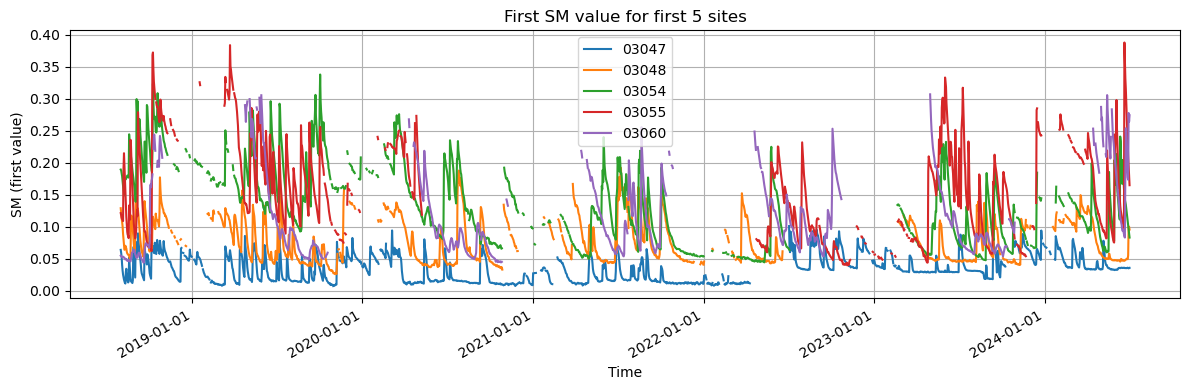

In [12]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator
import numpy as np

assert 'INSITU_sm' in globals(), "INSITU_sm not loaded"
assert 'timestamps' in globals(), "timestamps not available"

n_time = INSITU_sm.shape[0]
n_sites_plot = min(5, INSITU_sm.shape[2])
timestamps_arr = np.array(timestamps)  # list of datetimes -> works with matplotlib

# prepare ids if available
ids = []
if 'INSITU_id' in globals():
    ids_arr = np.atleast_1d(INSITU_id).ravel()
    for a in ids_arr[:n_sites_plot]:
        v = a
        if isinstance(v, np.ndarray): v = np.squeeze(v)
        if isinstance(v, bytes): v = v.decode('utf-8')
        ids.append(str(v))
else:
    ids = [str(i) for i in range(n_sites_plot)]

plt.figure(figsize=(12, 4))
for i in range(n_sites_plot):
    series = INSITU_sm[:, 0, i].astype(float)  # first SM value
    plt.plot(timestamps_arr, series, label=ids[i])

plt.xlabel('Time')
plt.ylabel('SM (first value)')
plt.title('First SM value for first 5 sites')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

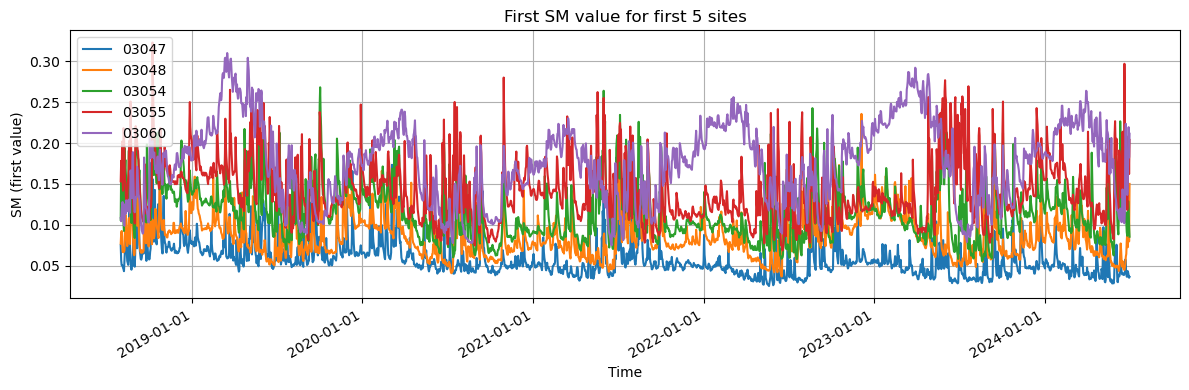

In [13]:
n_time = INSITU_sm.shape[0]
n_sites_plot = min(5, INSITU_sm.shape[2])
timestamps_arr = np.array(timestamps)  # list of datetimes -> works with matplotlib

# prepare ids if available
ids = []
if 'INSITU_id' in globals():
    ids_arr = np.atleast_1d(INSITU_id).ravel()
    for a in ids_arr[:n_sites_plot]:
        v = a
        if isinstance(v, np.ndarray): v = np.squeeze(v)
        if isinstance(v, bytes): v = v.decode('utf-8')
        ids.append(str(v))
else:
    ids = [str(i) for i in range(n_sites_plot)]

plt.figure(figsize=(12, 4))
for i in range(n_sites_plot):
    series = LDAS_sm_OL[:, 0, i].astype(float)  # first SM value
    plt.plot(timestamps_arr, series, label=ids[i])

plt.xlabel('Time')
plt.ylabel('SM (first value)')
plt.title('First SM value for first 5 sites')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()